How to run a simple N-body code
====================

Here we will generate initial conditions for an N-body code, run a small simulation and analyse the results. This analysis is performed on a 100 star cluster in a 1 pc virial-radius King model. Stellar masses are taken randomly from a Salpeter distribution.
Stellar evolution is ignored in this simulation.

For reference you can read chapter 2 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate initial conditions (mass function, King-model)
- to initialize a gravitational N-body code
- channels and intra-code data transfer
- detecting binaries
- plotting results
- making cumulative distributions

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import units

We start by setting-up a simulation by specifying a stellar mass distribution

In [2]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 0.1|units.MSun, 
                                        100|units.MSun, alpha_IMF)

Now check to see if this indeed gives one the expected mass function by plotting the cumulative distribution against a theoretical distribution.

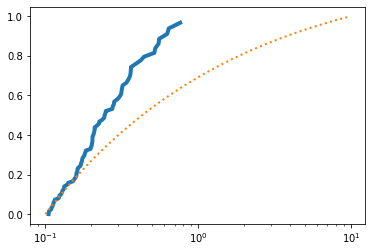

In [3]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = np.array([0])
    for mi in m:
        fm = np.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    plt.plot(m, fm[:len(m)], lw=4, ls="-")
    x = 10**np.arange(-1.0, 1.0, 1./len(m))
    y = x**(alpha_IMF+2)
    fy = np.array([0])
    for yi in y:
        fy = np.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    plt.plot(x, fy[:len(x)], lw=2, ls=":")
    plt.semilogx()
    plt.show()
plot_cdf(m_stars)

### Question:
Can you explain why the dotted curve does not overplot with the solid curve?

<span style="color:purple;font-weight:700">
--> we hebben maar 100 sterren, en er zit statistische variatie in
</span>

Now we can initialize the cluster size and declare the converter.

### Converter
N-body codes operate using special dimensionless N-body units (where the gravitational constant is set to unity). In order to make the code understand SI units, we must pass it a unit converter. This contains two quantities in the relevant unit system, from which AMUSE derives the proper unit conversion. Best practice is to keep those quantities on the order of the system's scale (e.g. the total mass and the radius of the outermost planet in a planetary system) to ensure numerical stability.

Also see the documentation on the importance of [converters](https://amuse.readthedocs.io/en/latest/reference/quantities_and_units.html?highlight=generic%20units#module-amuse.units.generic_unit_system) in AMUSE. 


In [13]:
r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_stars, W0, convert_nbody=converter)
bodies.scale_to_standard(converter)

Check the result by plotting the X-Y positions of the bodies.

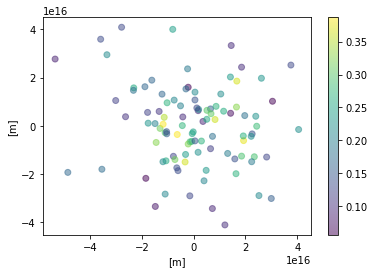

In [14]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x, bodies.y, c=v.value_in(units.kms), alpha=0.5)
    plt.colorbar()
    plt.show()
plot_snapshot(bodies)

cluster at Time= 0.0 Myr Mass= 22.4970103164 MSun Rvir= 1.0 parsec
cluster at Time= 10.0 Myr Mass= 22.4970103164 MSun Rvir= 1.00948007794 parsec
cluster at Time= 20.0 Myr Mass= 22.4970103164 MSun Rvir= 0.944257989449 parsec
cluster at Time= 30.0 Myr Mass= 22.4970103164 MSun Rvir= 1.02908062597 parsec
cluster at Time= 40.0 Myr Mass= 22.4970103164 MSun Rvir= 0.961712447485 parsec
cluster at Time= 50.0 Myr Mass= 22.4970103164 MSun Rvir= 0.954247745898 parsec
cluster at Time= 60.0 Myr Mass= 22.4970103164 MSun Rvir= 1.04981418255 parsec
cluster at Time= 70.0 Myr Mass= 22.4970103164 MSun Rvir= 1.10456923813 parsec
cluster at Time= 80.0 Myr Mass= 22.4970103164 MSun Rvir= 0.988706443144 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m *

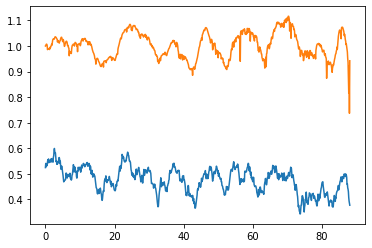

88.1 Myr


In [15]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = ph4(converter)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)

times = np.arange(0, 100, 0.1) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.Myr)%10.0:
    #print('(time%10.0):',(time.value_in(units.Myr)%10.0))
    #if ((time.value_in(units.Myr)%10.0) < 0.01) or ((time.value_in(units.Myr)%10.0 - 10) > -0.01):
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
    b = bodies.get_binaries()
    if(len(b)>0):
        print("Number of binaries found:", len(b))
        print("first binary:", b[0])
        break

#plt.plot(times[len(RL25)], RL25.value_in(units.parsec))

plt.plot(times[:len(RL25)].value_in(units.Myr), RL25.value_in(units.parsec))
plt.plot(times[:len(Rvir)].value_in(units.Myr), Rvir.value_in(units.parsec))
plt.show()

gravity.stop()

print(time)


You have now calculated the dynamical evolution of a small cluster of stars including a realistic mass function.

Assignments and questions:
---------------

### Question 1:
Why do we have to *scale_to_standard()* after assigning the masses and positions to all the particles?

<span style="color:red;font-weight:700">
Answer
</span>

### Question 2:
Run the notebook and describe the evolution of the virial radius.

<span style="color:purple;font-weight:700">
The radius oscillates, but (often) with decreasing amplitude over time
</span>

### Assignment 2:
There is a check for binary detection in the script.
If no binary formed in your run, that is okay.

Run the script again until a binary forms.

### Question 3:
One of the parameters in the binary is the *hardness*.
What is the hardness of the binary from your last run? and explain what is meant with this parameter.

<span style="color:purple;font-weight:700">
From documentation: "binaries are selected according to a hardness criterion [hardness=10]". 
The binary has hardness 1.030e+01, which corresponds to the criterion of hardness=10 to count as a binary.
</span>

### Assignment 3:
Rewrite the script in such a way that the event loop over time continues indefinitely, but that the code stops as soon as the first binary is detected.

Run the script several times until you have enough first binaries formed to make a histogram of the first-binary formation time-scale.

In [32]:
def binarymaker():
    converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
    W0 = 3.0
    bodies=new_king_model(n_stars, W0, convert_nbody=converter)
    bodies.scale_to_standard(converter)

    #plot_snapshot(bodies)

    gravity = ph4(converter)
    gravity.particles.add_particles(bodies)
    # A channel is a 'permanent' connection to a code's particle
    # set. Multiple calls to a code's particle set need to set up
    # a new connection every time; with a channel, we can copy
    # information back without opening a new connection.
    # This does not automatically update bodies! See below
    channel = gravity.particles.new_channel_to(bodies)

    times = np.arange(0, 100, 0.1) | units.Myr
    #timestep = 0.1 | units.Myr
    time = 0 | units.Myr
    times = np.array([]) | units.Myr
    RL25 = [] | units.parsec
    Rvir = [] | units.parsec
    b = []
    #for time in times:
    while len(b) == 0:
        time += 0.1 | units.Myr
        gravity.evolve_model(time)
        channel.copy() # Copy from gravity.particles to bodies
        Rvir.append(bodies.virial_radius())
        L = LagrangianRadii(bodies)
        RL25.append(LagrangianRadii(bodies)[5])
        '''
        if ((time.value_in(units.Myr)%10.0) < 0.01) or ((time.value_in(units.Myr)%10.0 - 10) > -0.01):
            print("cluster at Time=", time.in_(units.Myr), 
                  "Mass=", bodies.mass.sum().in_(units.MSun),
                  "Rvir=", Rvir[-1].in_(units.parsec))
        '''
        
        b = bodies.get_binaries()
        if(len(b)>0):
            print("Number of binaries found:", len(b))
            #print("first binary:\n", b[0])
            print("at time", time)
            #break

    gravity.stop()
    
    '''
    times = np.arange(0, time.number, 0.1) | units.Myr
    plt.plot(times.value_in(units.Myr), RL25.value_in(units.parsec), label='RL25')
    plt.plot(times.value_in(units.Myr), Rvir.value_in(units.parsec), label='Rvir')
    plt.xlabel('time (Myr)')
    plt.ylabel('radius (parsec)')
    plt.legend()
    plt.show()
    '''
    
    #print(time)
    return b[0], time

#testbinary, testtime = binarymaker()

In [26]:
#time_of_first_binary = np.array([]) | units.Myr
#first_binaries = np.array([])
# commented out to not accidentally empty the arrays

In [37]:
n = 10
for i in range(n):
    print(f'\nRun {i+1}/{n}')
    binary, tijd = binarymaker()
    first_binaries = np.append(first_binaries, binary)
    time_of_first_binary = np.append(time_of_first_binary, tijd)
    print(f'Total number of successful runs: {len(time_of_first_binary)}')
print(first_binaries)
print(time_of_first_binary)


Run 1/10
Number of binaries found: 1
at time 97.69999999999872 Myr
Total number of successful runs: 61

Run 2/10
Number of binaries found: 1
at time 151.0999999999957 Myr
Total number of successful runs: 62

Run 3/10
Number of binaries found: 1
at time 115.6999999999977 Myr
Total number of successful runs: 63

Run 4/10
Number of binaries found: 1
at time 105.39999999999829 Myr
Total number of successful runs: 64

Run 5/10
Number of binaries found: 1
at time 210.9999999999923 Myr
Total number of successful runs: 65

Run 6/10
Number of binaries found: 1
at time 137.89999999999645 Myr
Total number of successful runs: 66

Run 7/10
Number of binaries found: 1
at time 66.10000000000052 Myr
Total number of successful runs: 67

Run 8/10
Number of binaries found: 1
at time 170.4999999999946 Myr
Total number of successful runs: 68

Run 9/10
Number of binaries found: 1
at time 159.6999999999952 Myr
Total number of successful runs: 69

Run 10/10
Number of binaries found: 1
at time 94.899999999998

In [36]:
n = 10
for i in range(n):
    print(f'\nRun {i+1}/{n}')
    binary, tijd = binarymaker()
    first_binaries = np.append(first_binaries, binary)
    time_of_first_binary = np.append(time_of_first_binary, tijd)
    print(f'Total number of successful runs: {len(time_of_first_binary)}')
    #print(time_of_first_binary)
print(first_binaries)
print(time_of_first_binary)


Run 1/10
Number of binaries found: 1
at time 204.0999999999927 Myr
Total number of successful runs: 51

Run 2/10
Number of binaries found: 1
at time 135.1999999999966 Myr
Total number of successful runs: 52

Run 3/10
Number of binaries found: 1
at time 129.39999999999694 Myr
Total number of successful runs: 53

Run 4/10
Number of binaries found: 1
at time 93.09999999999899 Myr
Total number of successful runs: 54

Run 5/10
Number of binaries found: 1
at time 116.49999999999766 Myr
Total number of successful runs: 55

Run 6/10
Number of binaries found: 1
at time 73.30000000000011 Myr
Total number of successful runs: 56

Run 7/10
Number of binaries found: 1
at time 93.49999999999896 Myr
Total number of successful runs: 57

Run 8/10
Number of binaries found: 1
at time 143.39999999999614 Myr
Total number of successful runs: 58

Run 9/10
Number of binaries found: 1
at time 261.699999999991 Myr
Total number of successful runs: 59

Run 10/10
Number of binaries found: 1
at time 164.59999999999

Now, make a small change to your initial conditions.
A variation could include the dimensionless depth of the potential of the initial King model, the slope of the initial-mass function, its lower limit, or the number of stars in the simulation).

Now redo the calculation in which you generate a histogram of moments of first-binary formation.

Make one figure with both distributions: the original distribution for first-binary formation time and the second series of runs (with the altered initial conditions.
Present both distributions as histograms and as cumulative distributions. 

### Question 4:
Can you understand the difference in first-binary formation-time based on the changes you introduced in the initial conditions?

<span style="color:purple;font-weight:700">
Answer
</span>

Did you perform enough runs to make a statistically significant statement about the time of first-binary formation?

<span style="color:purple;font-weight:700">
Answer
</span>

### Assignment 4:
Make a cumulative distribution of the masses of the two stars for each first binary and compare it to the initial mass-function.

### Question 5:
Can you understand the difference between the typical masses of the binaries that formed first and the initial mass-function?

<span style="color:purple;font-weight:700">
Answer
</span>

In [ ]:
print(time_of_first_binary)
plt.plot(range(len(time_of_first_binary)), time_of_first_binary)

In [ ]:
# 111.6 Myr
# 60.0-70.0 Myr
# 94.4 Myr
# 122.7 Myr
# 194.1 Myr
# 96.2 Myr
# 175.2 Myr
# [quantity<127.09999999999705 Myr> quantity<102.59999999999845 Myr> 
# quantity<167.29999999999478 Myr> quantity<139.89999999999634 Myr>]
# [quantity<109.09999999999808 Myr> quantity<81.29999999999966 Myr>
# quantity<101.49999999999851 Myr>]
# [quantity<112.79999999999787 Myr> quantity<138.19999999999644 Myr>
# quantity<188.99999999999355 Myr>]
# [quantity<78.29999999999983 Myr> quantity<164.9999999999949 Myr>
# quantity<182.7999999999939 Myr>]
# [quantity<78.29999999999983 Myr> quantity<164.9999999999949 Myr>
# quantity<182.7999999999939 Myr>]

# [quantity<117.4999999999976 Myr> quantity<132.89999999999674 Myr>
# quantity<121.19999999999739 Myr> quantity<163.79999999999498 Myr>
# quantity<106.19999999999824 Myr> quantity<119.49999999999748 Myr>]

# quantity<243.29999999999046 Myr> quantity<168.09999999999474 Myr>
# quantity<121.69999999999736 Myr> quantity<81.39999999999965 Myr>]

'''[quantity<117.4999999999976 Myr> quantity<132.89999999999674 Myr>
 quantity<121.19999999999739 Myr> quantity<163.79999999999498 Myr>
 quantity<106.19999999999824 Myr> quantity<119.49999999999748 Myr>
 quantity<243.29999999999046 Myr> quantity<168.09999999999474 Myr>
 quantity<121.69999999999736 Myr> quantity<81.39999999999965 Myr>
 quantity<111.99999999999791 Myr> quantity<137.89999999999645 Myr>
 quantity<149.3999999999958 Myr> quantity<190.29999999999347 Myr>
 quantity<156.1999999999954 Myr> quantity<95.29999999999886 Myr>
 quantity<98.99999999999865 Myr> quantity<110.69999999999798 Myr>
 quantity<174.39999999999438 Myr> quantity<120.39999999999743 Myr>
 quantity<117.29999999999761 Myr> quantity<140.19999999999632 Myr>
 quantity<82.99999999999956 Myr> quantity<177.3999999999942 Myr>
 quantity<161.99999999999508 Myr> quantity<105.59999999999827 Myr>
 quantity<37.50000000000026 Myr> quantity<143.69999999999612 Myr>
 quantity<86.49999999999936 Myr> quantity<111.19999999999796 Myr>
 quantity<106.39999999999823 Myr> quantity<158.89999999999526 Myr>
 quantity<84.89999999999945 Myr> quantity<100.09999999999859 Myr>
 quantity<96.3999999999988 Myr> quantity<126.59999999999708 Myr>
 quantity<81.19999999999966 Myr> quantity<201.19999999999285 Myr>
 quantity<118.49999999999754 Myr> quantity<153.0999999999956 Myr>
 quantity<61.80000000000061 Myr> quantity<196.09999999999314 Myr>
 quantity<109.99999999999802 Myr>]'''